# In-class Assignment 3 - Classification Problem <Hr>

## Submitted by: Aarjeyan Shrestha C0927422 <hr>

### About Dataset
##### Context

In this assignment, we delve into a dataset for distinguishing the presence of heart disease for which the target features have value 0 and 1, 0 being the absence of heart disease and 1 being the presence of heart disease.

Number of Instances: 920

Number of Attributes: 16

Missing Values: yes

Dataset :[https://archive.ics.uci.edu/dataset/45/heart+disease](https://archive.ics.uci.edu/dataset/45/heart+disease)

## Dataset Description:

| Variable   | Description                                                                                   |
|------------|-----------------------------------------------------------------------------------------------|
| age        | Age of the patient in years                                                                   |
| sex        | Gender of the patient (0 = male, 1 = female)                                                  |
| cp         | Chest pain type: 0: Typical angina, 1: Atypical angina, 2: Non-anginal pain, 3: Asymptomatic |
| trestbps   | Resting blood pressure in mm Hg                                                               |
| chol       | Serum cholesterol in mg/dl                                                                    |
| fbs        | Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false)               |
| restecg    | Resting electrocardiographic results: 0: Normal, 1: Having ST-T wave abnormality, 2: Showing probable or definite left ventricular hypertrophy |
| thalach    | Maximum heart rate achieved during a stress test                                              |
| exang      | Exercise-induced angina (1 = yes, 0 = no)                                                     |
| oldpeak    | ST depression induced by exercise relative to rest                                             |
| slope      | Slope of the peak exercise ST segment: 0: Upsloping, 1: Flat, 2: Downsloping                   |
| ca         | Number of major vessels (0-4) colored by fluoroscopy                                           |
| thal       | Thalium stress test result: 0: Normal, 1: Fixed defect, 2: Reversible defect, 3: Not described |
| target     | Heart disease status (0 = no disease, 1 to 4 = presence of disease, 1=mild, 2= moderate, 3=severe, 4=critical) later changed to 0 and 1                                |


<hr>

<hr>

## 1. Importing Libraries

In [4]:
# import libraries

# 1. to handle the data
import pandas as pd


# To preprocess the data
from sklearn.preprocessing import LabelEncoder

# import iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# machine learning
from sklearn.model_selection import train_test_split
#for classification tasks
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

#metrics
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Loading the dataset

In [5]:
df = pd.read_csv("heart_disease_uci.csv",delimiter=",")

In [6]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## 3. Data Preperation

### 3.1 Checking Missing Values

In [7]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [8]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)

ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
dtype: int64

So, these are the missing columns with its missing values.

Seperating the features into categorical columns, boolean columns and numerical columns.

In [9]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [10]:
# columns whose data are missing
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
missing_data_cols

['trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalch',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

### 3.2 Handling Missing value by imputation

The below is the code that I found in the stack overflow for the imputation of the missing value in the categorical and continuous columns seperately. <br>

It uses the advance methods like ``Random Forest`` and ``Iterative Imputer`` for the imputation, which are more accurate then using Mean, Median or Mode. <br>

We define a function for imputing missing values, in which we passed teh columns names and the function returns a dataset with no missing values.

Methods used in the functions are:<br>
1. Random Forest Classifier <br>
2. Random Forest Regressor <br>
3. Iterative Imputer <br>

In [11]:
# define the function to impute the missing values in missing column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [12]:
# remove warning
import warnings
warnings.filterwarnings('ignore')

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values trestbps : 6.41%
MAE = 13.445317919075144 

RMSE = 17.458278027236837 

R2 = 0.04834264576090619 

Missing Values chol : 3.26%
MAE = 44.36887640449438 

RMSE = 62.860067181537566 

R2 = 0.686982709983053 

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 80.12 accuracy

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 64.67 accuracy

Missing Values thalch : 5.98%
MAE = 16.44838150289017 

RMSE = 21.355516391481167 

R2 = 0.3368535204374776 

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 78.03 accuracy

Missing Values oldpeak : 6.74%
MAE = 0.5810872093023256 

RMSE = 0.8078939279615915 

R2 = 0.37817721168582286 

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 66.67 accuracy

Missing Values ca : 66.41%
The feature 'ca' has been imputed with 64.52 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 72.41 accuracy



### Here, the missing values of different features are imputed with different accuracy
1. fbs - imputed with 80.12 accuracy
2. restecg - imputed with 64.67 accuracy
3. exang - imputed with 78.03 accuracy <br> and so on

In [13]:
# checking for missing values again
df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In this way, the missing values have been imputed using the defined function. 

### 3.3 Handling Outliers

In [14]:
# print the row from df where trestbps value is 0
df[df['trestbps'] == 0]
# remove this row from data
df = df[df['trestbps'] != 0]

In [15]:
# Saving The Cleaned Data 
#df.to_csv('heart_disease_cleaned.csv', index=False)

While dealing with outlier, there is only one outlier in the dataset which i removed above

### 3.4 Renaming different attributes and Encoding some features.

- Renaming Column Names and Dropping some irrelevant columns.
- I drop irrelevant columns like: `id`, `restecg` and use columns that are important.
- In Thal and cp columns we have space in the different values. so I remove theose spaces
- In `target` column 0: No disease and 1: Disease... but we have value from 1 to 4 which shows the severity of the disease. 
- so making only two categories as 0: having no disease and 1: having disease

In [16]:
data = df.copy()

In [17]:
# In some of the features, there is space will will create problem later on. 
# So we rename those attributes to handle problems in the future.
data['thal'].replace({'fixed defect':'fixed_defect' , 'reversable defect': 'reversable_defect' }, inplace =True)
data['cp'].replace({'typical angina':'typical_angina', 'atypical angina': 'atypical_angina' }, inplace =True)
data['restecg'].replace({'normal': 'normal' , 'st-t abnormality': 'ST-T_wave_abnormality' , 'lv hypertrophy': 'left_ventricular_hypertrophy' }, inplace =True)

# Genrating New Dataset with Less Columns Which Are Necessary .
data_1 = data[['age','sex','cp','dataset', 'trestbps', 'chol', 'fbs','restecg' , 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']].copy()
# Some Changes in Target Variable | Only Two Categories (0,1) . 0 for No-Disease , 1 for Disease
data_1['target'] = ((data['num'] > 0)*1).copy()
# Encoding Sex 
data_1['sex'] = (data['sex'] == 'Male')*1
# Encoding Fbs and exang
data_1['fbs'] = (data['fbs'])*1
data_1['exang'] = (data['exang'])*1
# Renaming COlumns Names.
data_1.columns = ['age', 'sex', 'chest_pain_type','country' ,'resting_blood_pressure', 
              'cholesterol', 'fasting_blood_sugar','Restecg',
              'max_heart_rate_achieved', 'exercise_induced_angina', 
              'st_depression', 'st_slope_type', 'num_major_vessels', 
              'thalassemia_type', 'target']
# Load Data Sample 
data_1.head()

,age,sex,chest_pain_type,country,resting_blood_pressure,cholesterol,fasting_blood_sugar,Restecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope_type,num_major_vessels,thalassemia_type,target
0,63,1,typical_angina,Cleveland,145.0,233.0,1,left_ventricular_hypertrophy,150.0,0,2.3,downsloping,0.0,fixed_defect,0
1,67,1,asymptomatic,Cleveland,160.0,286.0,0,left_ventricular_hypertrophy,108.0,1,1.5,flat,3.0,normal,1
2,67,1,asymptomatic,Cleveland,120.0,229.0,0,left_ventricular_hypertrophy,129.0,1,2.6,flat,2.0,reversable_defect,1
3,37,1,non-anginal,Cleveland,130.0,250.0,0,normal,187.0,0,3.5,downsloping,0.0,normal,0
4,41,0,atypical_angina,Cleveland,130.0,204.0,0,left_ventricular_hypertrophy,172.0,0,1.4,upsloping,0.0,normal,0


### 3.5 Feature Scalling (Done inside each function model)

For feature scalling I used MinMaxScaler as it normalizes the features of a dataset, which scales the features to a specific range, usually between 0 and 1.

## 4. Train-Test Split (Done inside each function)

We split the data into 70% training and 30% testing data for all the models 

## 5. Classification 

#### In this Assignment I used 2 models for the classificaiton purpose.

1. `Random Forest Classifier` - base and tuned <br>
2. `XGBoost Classifier` - base and tuned

For each of these 2 models, I trained the Base Model and Hyperparameter tuned Model. Also for each model, I displayed the confusion matrics to show how the true labels are being depicted by the model. <br>

After this I compared the results of all 4 models trained and showed it using the comparison table and barplot.

As a end result, I showed the comparison between the `Accuracy`, `Precision`, `Recall` and `F1-score` for all the models (base and tuned.)

### Defining function for Random Forest Base Model

In [18]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_random_forest_base_model(data, target):
    # Dictionary to store LabelEncoders for each categorical column
    label_encoders = {}

    # split the data into X and y
    X = data.drop(target, axis=1)
    y = data[target]

    # Create a new LabelEncoder for each categorical column
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Scaling Data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the Random Forest model
    rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')

    # Train the model on the training set
    rf_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Accuracy on Test Set: {accuracy:.2f}')
    print(f'Precision on Test Set: {precision:.2f}')
    print(f'Recall on Test Set: {recall:.2f}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Inverse transform at the End
    # Loop through each column to decode the data
    for col, le in label_encoders.items():
        # Use the inverse_transform method to decode the column in both training and test sets
        X[col] = le.inverse_transform(X[col])

    return rf_model, accuracy, precision, recall, f1


### Defining function for Random Forest Hyperparameter tuning model

In [19]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_random_forest(data, target):
    # Dictionary to store LabelEncoders for each categorical column
    label_encoders = {}

    # split the data into X and y
    X = data.drop(target, axis=1)
    y = data[target]

    # Create a new LabelEncoder for each categorical column
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Scaling Data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the Random Forest model
    rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')

    # Define hyperparameters for tuning
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_rf_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Print the best hyperparameters
    print('Best Hyperparameters:')
    print(best_params)

    # Train the model on the full training set
    best_rf_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = best_rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Accuracy on Test Set: {accuracy:.2f}')
    print(f'Precision on Test Set: {precision:.2f}')
    print(f'Recall on Test Set: {recall:.2f}')
    print(f'F1 Score on Test Set: {f1:.2f}')
    
     # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Inverse transform at the End
    # Loop through each column to decode the data
    for col, le in label_encoders.items():
        # Use the inverse_transform method to decode the column in both training and test sets
        X[col] = le.inverse_transform(X[col])

    return best_rf_model, best_params, accuracy, precision, recall, f1


### Defining function for XGBoost base model

In [20]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_xgb_classifier_base_model(data, target):
    # Dictionary to store LabelEncoders for each categorical column
    label_encoders = {}

    # split the data into X and y
    X = data.drop(target, axis=1)
    y = data[target]

    # Create a new LabelEncoder for each categorical column
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Scaling Data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the XGBClassifier model
    xgb_model = XGBClassifier(random_state=0)

    # Train the model on the training set
    xgb_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Accuracy on Test Set: {accuracy:.2f}')
    print(f'Precision on Test Set: {precision:.2f}')
    print(f'Recall on Test Set: {recall:.2f}')
    print(f'F1 Score on Test Set: {f1:.2f}')
    
     # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Inverse transform at the End
    # Loop through each column to decode the data
    for col, le in label_encoders.items():
        # Use the inverse_transform method to decode the column in both training and test sets
        X[col] = le.inverse_transform(X[col])

    return xgb_model, accuracy, precision, recall, f1


### Defining function for XGBoost Hyperparameter tuning model

In [21]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_xgb_classifier(data, target):
    # Dictionary to store LabelEncoders for each categorical column
    label_encoders = {}

    # split the data into X and y
    X = data.drop(target, axis=1)
    y = data[target]

    # Create a new LabelEncoder for each categorical column
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Scaling Data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the XGBClassifier model
    xgb_model = XGBClassifier(random_state=0)

    # Define hyperparameters for tuning
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1, 2]
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_xgb_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Print the best hyperparameters
    print('Best Hyperparameters:')
    print(best_params)

    # Train the model on the full training set
    best_xgb_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = best_xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Accuracy on Test Set: {accuracy:.2f}')
    print(f'Precision on Test Set: {precision:.2f}')
    print(f'Recall on Test Set: {recall:.2f}')
    print(f'F1 Score on Test Set: {f1:.2f}')
    
     # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Inverse transform at the End
    # Loop through each column to decode the data
    for col, le in label_encoders.items():
        # Use the inverse_transform method to decode the column in both training and test sets
        X[col] = le.inverse_transform(X[col])

    return best_xgb_model, best_params, accuracy, precision, recall, f1


## 6. Results and Visualizations

### 6.1 Result for Random Forest Base Model

After Training Random Forest Base Model we got the results as: 
Accuracy on Test Set: 0.85
Precision on Test Set: 0.85
Recall on Test Set: 0.85
F1 Score on Test Set: 0.85


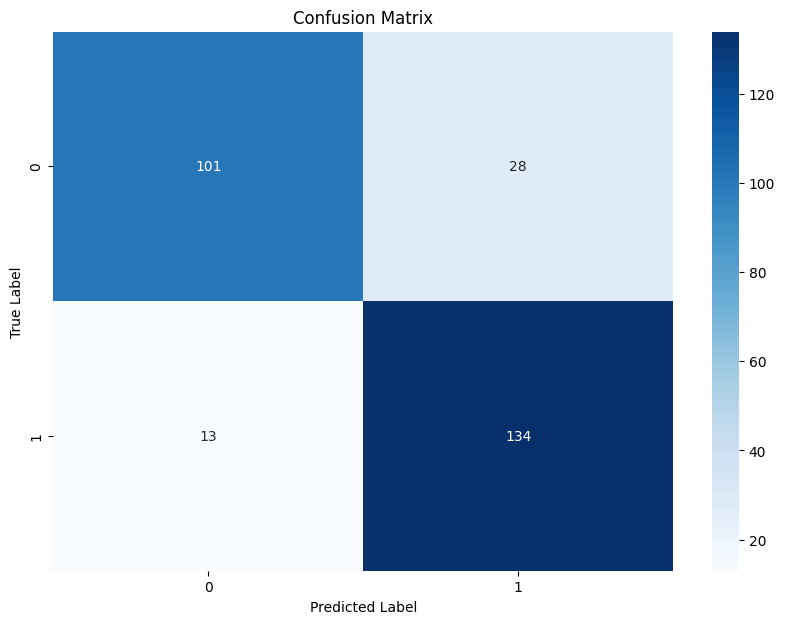

In [22]:
# Training the Random Forest base model
print(f"After Training Random Forest Base Model we got the results as: ")
base_rf_model, base_rf_accuracy, base_rf_precision, base_rf_recall, base_rf_f1 = train_random_forest_base_model(data_1, "target")
print()

### 6.2 Result for Random Forest Hyperparameter-tuned Model

After Training Random Forest Hyperparameter tuning model we got the results as: 
Best Hyperparameters:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy on Test Set: 0.86
Precision on Test Set: 0.86
Recall on Test Set: 0.86
F1 Score on Test Set: 0.86


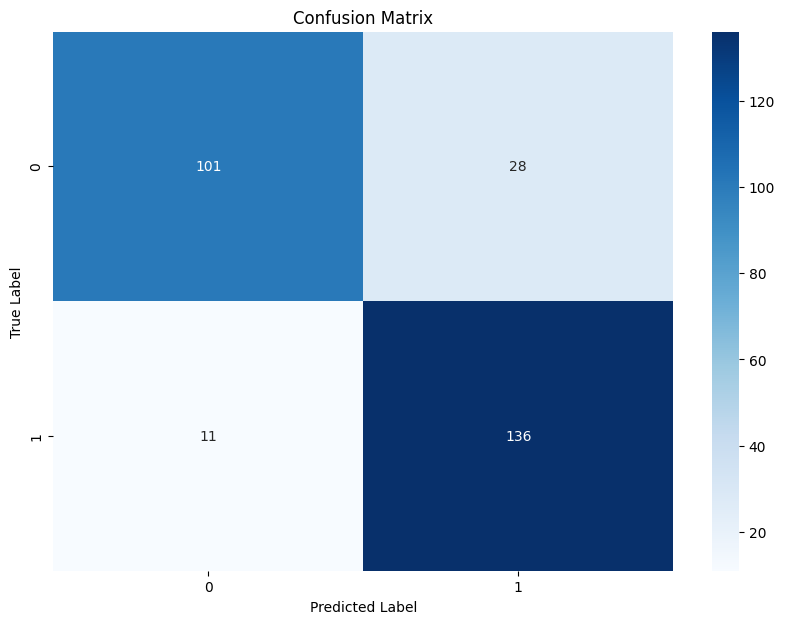

In [23]:
# Random forest hyperparameter-tuned model
print(f"After Training Random Forest Hyperparameter tuning model we got the results as: ")
best_rf_model, best_rf_params, best_rf_accuracy, best_rf_precision, best_rf_recall, best_rf_f1 = train_random_forest(data_1, "target")
print()

### 6.3 Result for XG Boost Base Model

After Training XGBoost Base Model we got the results as: 
Accuracy on Test Set: 0.84
Precision on Test Set: 0.84
Recall on Test Set: 0.84
F1 Score on Test Set: 0.84


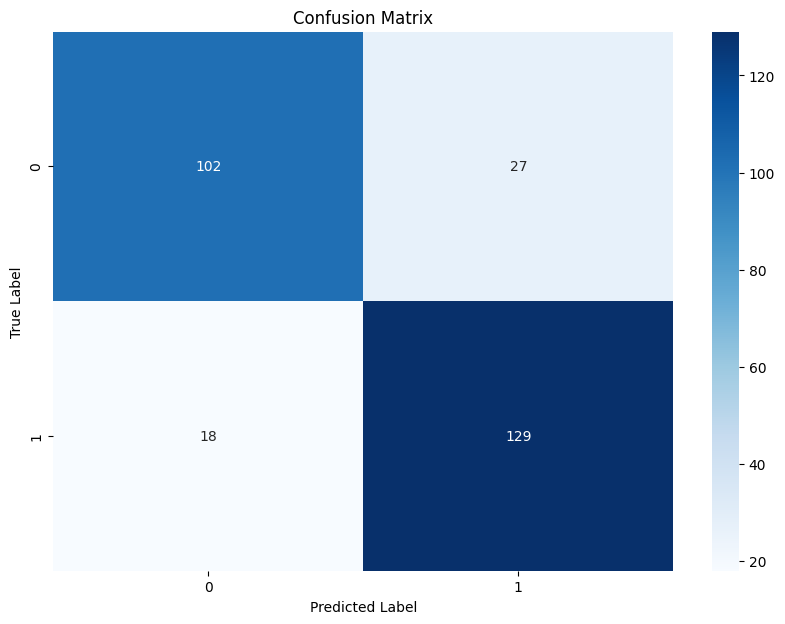

In [24]:
## Training XG boost base model 
print(f"After Training XGBoost Base Model we got the results as: ")
base_xgb_model, base_xgb_accuracy, base_xgb_precision, base_xgb_recall, base_xgb_f1 = train_xgb_classifier_base_model(data_1, "target")
print()


### 6.4 Result for XGBoost Hyperparameter tuned model

After Training XGBoost Hyperparameter tuning model we got the results as: 
Best Hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Accuracy on Test Set: 0.86
Precision on Test Set: 0.86
Recall on Test Set: 0.86
F1 Score on Test Set: 0.85


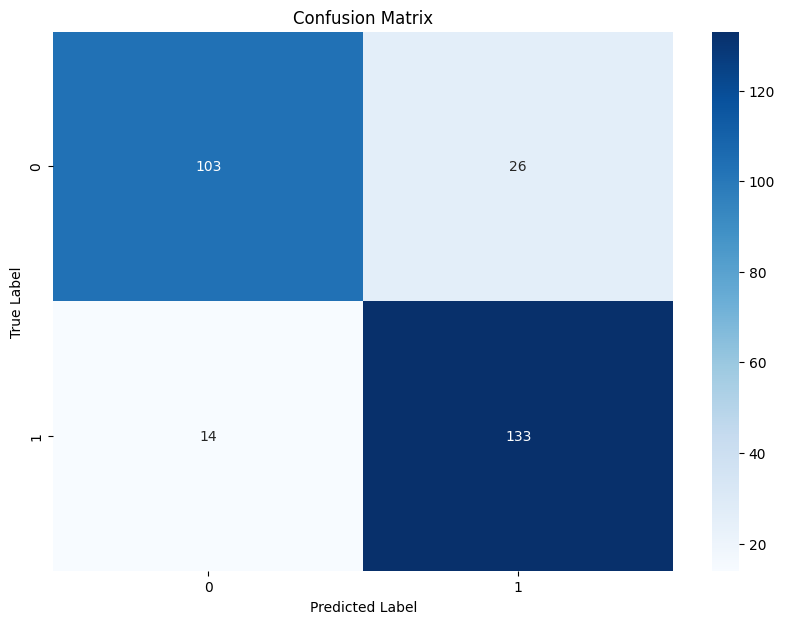

In [25]:
# ## Training XG boost hyperparameter-tuned model
print(f"After Training XGBoost Hyperparameter tuning model we got the results as: ")
best_xgb_model, best_xgb_params, best_xgb_accuracy, best_xgb_precision, best_xgb_recall, best_xgb_f1 = train_xgb_classifier(data_1, "target")
print()

### 6.5 Comparison Table for all models

In [26]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Classifier': ['Random Forest', 'Random Forest (Tuned)', 'XGBoost', 'XGBoost (Tuned)'],
    'Accuracy': [base_rf_accuracy, best_rf_accuracy, base_xgb_accuracy, best_xgb_accuracy],
    'Precision': [base_rf_precision, best_rf_precision, base_xgb_precision, best_xgb_precision],
    'Recall': [base_rf_recall, best_rf_recall, base_xgb_recall, best_xgb_recall],
    'F1-Score': [base_rf_f1, best_rf_f1, base_xgb_f1, best_xgb_f1]
})

comparison_df

,Classifier,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.851449,0.854645,0.851449,0.850470
1,Random Forest (Tuned),0.858696,0.863162,0.858696,0.857574
2,XGBoost,0.836957,0.837709,0.836957,0.836431
3,XGBoost (Tuned),0.855072,0.856980,0.855072,0.854379


### Visualization showing results for all models

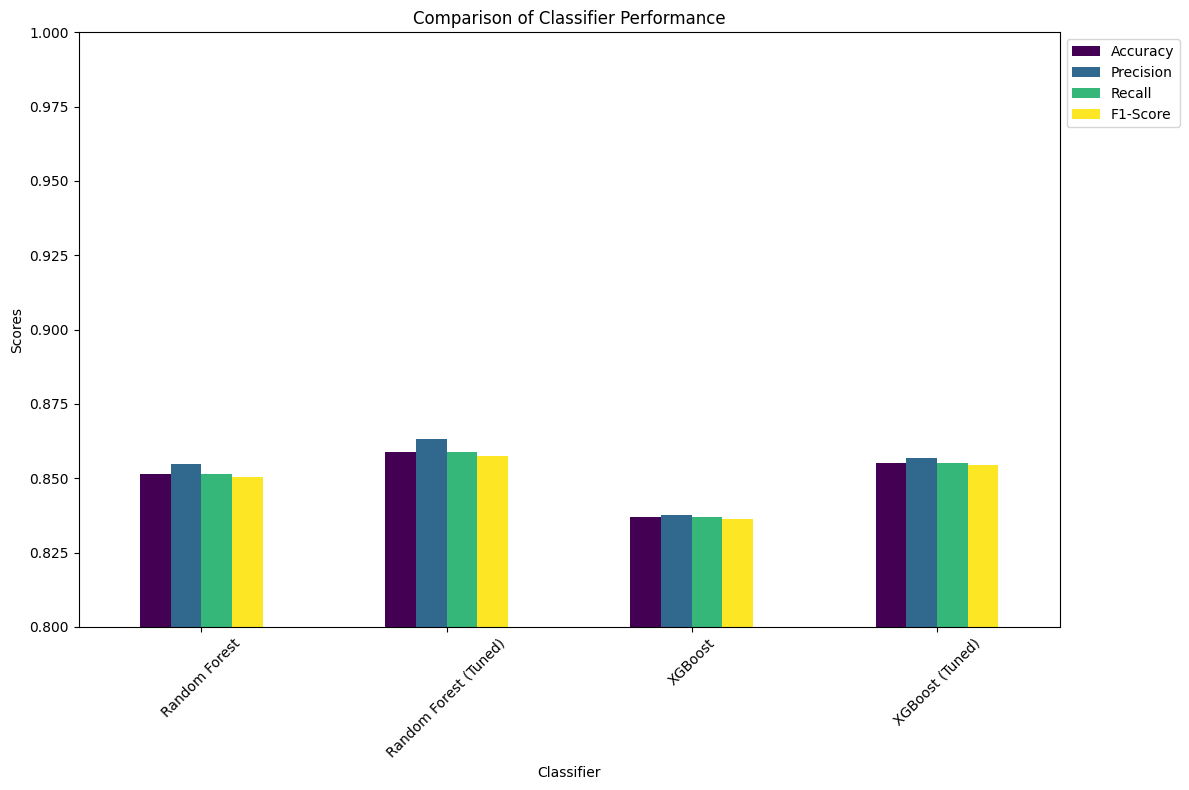

In [27]:
# Plotting the comparison DataFrame
comparison_df.set_index('Classifier', inplace=True)
comparison_df.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Comparison of Classifier Performance')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.ylim(0.8, 1)  # Adjust the y-axis range to focus on values between 0.8 and 1
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Thank you